<a href="https://colab.research.google.com/github/rdiazrincon/SLEAP_Data/blob/master/analysis/prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost can better predict outcome from Mouse location in Reward Competition assay 

## Introduction

The study of naturalistic social behavior requires quantification of animals’ interaction. This is significant because it enables us to comprehend the neural dynamics that govern social behavior. However, this is a time-consuming process that is usually accomplished through manual annotation. To annotate the behavior, scientists must sit in front of a computer and not only annotate the body parts of many animals, but also keep track of the time when the trial takes place and, in our case, score who is the winner or loser in a specific competition.

Despite recent advances in computer vision that has enabled the development of tools that perform animal pose estimation, such as [SLEAP](sleap.ai/), which was used for this project, most of these tools do not include packages or are suited for behavior classification. As a result, classifying complex behavior remains a challenge.

Motivated by these challenges and the desire to quantify social behavior, we present a Supervised Machine Learning-based approach to predicting the outcome of a reward competition, that is, determining which mouse is the winner or loser.

The reward competition assay consists of the following: There are cagemates mice. For each trial, a sugary reward is released in the reward port 4 seconds after the trial begins, and the mice compete to get there first. The trial lasts 10 seconds and there are 20 trials in total. The data in this notebook represents the mouse location troughout the video, in including the comptetions and the outcome of each one. 


### (Optional) Installing required packages

**Note:** If you are runnning this Notebook from Colab most packages will be already installed. But please do so if you are running locally.

In [1]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install tables
# !pip install xgboost

### Importing packages

In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d

### Getting the data from Github 

**Note:** Run this if you are using Colab. It will save the labeled data in your current directory.

In [3]:
# !wget -O prediction_analysis.h5 https://github.com/rdiazrincon/ml_behavioral_quantification/blob/master/data/prediction_analysis.h5

### Setting up the paths for labeled data and reward competition info

In [4]:
path = "data/prediction_analysis.h5"
intervals = "data/WL_info_by_timestamp.csv"

## Data Exploration

### Taking a look at the data

In [5]:
# Opening the H5 file
with h5py.File(path, "r") as f:
    dataset_keys = list(f.keys())
    tracks = f["tracks"][:].T
    bodyparts = [n.decode() for n in f["node_names"][:]]

print(f"Filename:{path}")
print(f"Array keys{dataset_keys}:")
print(f"Behavioral data shape:{tracks.shape}")
print(f"Body parts{bodyparts}")

Filename:data/prediction_analysis.h5
Array keys['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']:
Behavioral data shape:(54546, 6, 2, 2)
Body parts['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']


### Understanding the data 

We only work with the tracks array. It contains information regarding Number of Frames, Number of Bodyparts, Number of Coordinates and Number of instances.


In [6]:
# Here's what each dimension of the matrix's shape means
n_frames, n_bodyparts, n_coordinates, n_instances = tracks.shape

print(f"Number of Frames: {n_frames}")
print(f"Number of Bodyparts: {n_bodyparts}")
print(f"Number of Coordinates: {n_coordinates}")
print(f"NUmber of Instances: {n_instances}")

Number of Frames: 54546
Number of Bodyparts: 6
Number of Coordinates: 2
NUmber of Instances: 2


### Exploring (and making sense out of) the data

- The tracks array contains all of the information we need. 
- The first dimension of the array will provide us with information regarding the frames labeled in the video. 
- The second dimension relates to each body part (6 in our case). Note that, in the example below, we get data from the forehead by accesing position 5 in the array. 
- The third dimension relates to the X and Y coordinates and the fourth dimension to the number if animals/mice/instances


#### First frame 

In [7]:
print(tracks[0])

[[[184.44789124 315.60144043]
  [351.55776978 379.87524414]]

 [[140.21481323 284.03588867]
  [364.47213745 367.95025635]]

 [[183.75314331 319.75219727]
  [404.18869019 427.59402466]]

 [[147.53791809 412.41549683]
  [208.04371643 216.35691833]]

 [[148.6204834  339.65484619]
  [324.4312439  299.75323486]]

 [[168.43464661 296.26281738]
  [367.9828186  387.65563965]]]


#### Forehead coordinates for both mouse in Frame 1

**Note:** You can find the forehead data in position 5 of the tracks array. In general, the "bodyparts" array contains information regarding the position of bodyparts.
 

In [8]:
print(tracks[0][5])

[[168.43464661 296.26281738]
 [367.9828186  387.65563965]]


#### Forehead X-coordinate for both mouse in Frame 1

In [9]:
print(tracks[0][5][0])

[168.43464661 296.26281738]


#### Forehead Y-coordinate for mouse 2 in Frame 1.

In [10]:
print(tracks[0][5][0][1]) 

296.2628173828125


## Data Handling

### Fill-in missing values

We won't drop the NaN values but will fill them with Non Zero values so the analysis is easier to make

In [11]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

After filling out the NaN values with None Zero values, the array maintains the same shape

In [12]:
tracks = fill_missing(tracks)
print(tracks.shape)

(54546, 6, 2, 2)


### Reading and handling information related to Reward Competition

The information in the Frames column relates to the frames that make up a Trial. We will be reading a file to get this information


In [13]:
df_trials = pd.read_csv(intervals)['Frame']
df_trials

0       2100-2400
1       4470-4770
2       7140-7440
3       9510-9810
4     11730-12030
5     14670-14970
6     17520-17820
7     20160-20460
8     22530-22830
9     25200-25500
10    28140-28440
11    30840-31140
12    34410-34710
13    37050-37350
14    39570-39870
15    42210-42510
16    45030-45330
17    48600-48900
18    50970-51270
19    53790-54090
Name: Frame, dtype: object

### Converting the trials DataFrame to an array

Using the dash to separate each trial in an array

In [14]:
trials_array_separated = [trial.split("-") for trial in df_trials] # Returns a list of lists
print(trials_array_separated)

[['2100', '2400'], ['4470', '4770'], ['7140', '7440'], ['9510', '9810'], ['11730', '12030'], ['14670', '14970'], ['17520', '17820'], ['20160', '20460'], ['22530', '22830'], ['25200', '25500'], ['28140', '28440'], ['30840', '31140'], ['34410', '34710'], ['37050', '37350'], ['39570', '39870'], ['42210', '42510'], ['45030', '45330'], ['48600', '48900'], ['50970', '51270'], ['53790', '54090']]


Looping through the nested array, converting each (str) element to int and appending the elements in a new array 


In [15]:
trials_array = [int(j) for i in range(len(trials_array_separated)) for j in trials_array_separated[i]]
print(trials_array)

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


## Getting information on mice coordinates based in trials 

For each body part, we loop through the set of frames that comprise a single trial. We repeat for all the trials in the competition (20).
Each video has 30 frames per second(FPS) and each trial lasts 10 second.

In [16]:
LEFT_EAR_INDEX = 0
RIGHT_EAR_INDEX = 1
NOSE_INDEX = 2
TAIL_BASE_INDEX = 3
THORAX_INDEX = 4
FOREHEAD_INDEX = 5

TRIAL_LENGTH_SECONDS = 10
N_TRIALS = 20
FPS = 30

time_window_seconds = 10

frames_per_trial = FPS * TRIAL_LENGTH_SECONDS
time_window_frames = FPS * time_window_seconds

left_ear_loc_aux = []
right_ear_loc_aux = []
nose_loc_aux = []
tail_base_loc_aux = []
thorax_loc_aux = []
forehead_loc_aux = []

Using the onset information to target a different set of frames. Now we are looking at the frames that occur 30 seconds prior to the tone onset and 30 seconds before the tone onset. That is, we will be looking at time_window_frames frames before and after

In [17]:
it = iter(trials_array)
trials_array_onset = []
for i, j in zip(it, it):
    trials_array_onset.append(i - time_window_frames)
    trials_array_onset.append(j)

In [18]:
print(trials_array_onset)

[1800, 2400, 4170, 4770, 6840, 7440, 9210, 9810, 11430, 12030, 14370, 14970, 17220, 17820, 19860, 20460, 22230, 22830, 24900, 25500, 27840, 28440, 30540, 31140, 34110, 34710, 36750, 37350, 39270, 39870, 41910, 42510, 44730, 45330, 48300, 48900, 50670, 51270, 53490, 54090]


In [19]:
print(trials_array)     

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


Using the trials_array to loop through the intervals (first_frame_in_trial:last_frame_in_trial) and fill the vector with the coordinates corresponding for both mice and their body parts  


In [20]:
iterator = iter(trials_array_onset)
for first_frame_in_trial, last_frame_in_trial in zip(iterator, iterator):
    # print(len(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :]))
    left_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, LEFT_EAR_INDEX, :, :])
    right_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :])
    nose_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, NOSE_INDEX, :, :])
    tail_base_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, TAIL_BASE_INDEX, :, :])
    thorax_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, THORAX_INDEX, :, :])
    forehead_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, FOREHEAD_INDEX, :, :])

frames_in_trial = last_frame_in_trial - first_frame_in_trial

In [21]:
array_shape = np.asarray(left_ear_loc_aux).shape
print(f"Old shape: {array_shape}")
left_ear_loc = np.asarray(left_ear_loc_aux).reshape(N_TRIALS * frames_in_trial , n_coordinates, n_instances)
print(f"New shape: {left_ear_loc.shape}")
right_ear_loc = np.asarray(right_ear_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
nose_loc = np.asarray(nose_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
tail_base_loc = np.asarray(tail_base_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
thorax_loc = np.asarray(thorax_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
forehead_loc = np.asarray(forehead_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)

Old shape: (20, 600, 2, 2)
New shape: (12000, 2, 2)


### Converting our data into a Tabular format

In [22]:
# There is definitely an easier way of doing this but I don't have the time now

bp = ['left_ear', 'right_ear', 'thorax', 'tail', 'nose']
coord = ['x', 'y']
for i in range(1):
    for j in range(1):
        df_bla = {
            'm{j}_{bp[{0}]}_{i}': left_ear_loc[:, i, j]
        }

df = pd.DataFrame({
    'm1_left_ear_x': left_ear_loc[:, 0, 0], 
    'm1_left_ear_y': left_ear_loc[:, 1, 0], 
    "m2_left_ear_x": left_ear_loc[:, 0, 1],
    "m2_left_ear_y": left_ear_loc[:, 1, 1],

    'm1_right_ear_x': right_ear_loc[:, 0, 0], 
    'm1_right_ear_y': right_ear_loc[:, 1, 0], 
    "m2_right_ear_x": right_ear_loc[:, 0, 1],
    "m2_right_ear_y": right_ear_loc[:, 1, 1],
    
    'm1_nose_x': nose_loc[:, 0, 0], 
    'm1_nose_y': nose_loc[:, 1, 0], 
    "m2_nose_x": nose_loc[:, 0, 1],
    "m2_nose_y": nose_loc[:, 1, 1],

    'm1_tail_base_x': tail_base_loc[:, 0, 0], 
    'm1_tail_base_y': tail_base_loc[:, 1, 0], 
    "m2_tail_base_x": tail_base_loc[:, 0, 1],
    "m2_tail_base_y": tail_base_loc[:, 1, 1],

    'm1_thorax_x': thorax_loc[:, 0, 0], 
    'm1_thorax_y': thorax_loc[:, 1, 0], 
    "m2_thorax_x": thorax_loc[:, 0, 1],
    "m2_thorax_y": thorax_loc[:, 1, 1],

    'm1_forehead_x': forehead_loc[:, 0, 0], 
    'm1_forehead_y': forehead_loc[:, 1, 0], 
    "m2_forehead_x": forehead_loc[:, 0, 1],
    "m2_forehead_y": forehead_loc[:, 1, 1],
    })
df

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
0,320.305115,379.579254,35.556240,383.408508,284.011261,368.348846,12.318925,348.103851,308.466034,424.620239,...,143.921066,288.100708,304.187805,315.714355,63.607273,335.775909,300.448608,391.507996,24.345795,364.285156
1,320.375641,379.575684,35.849640,383.613434,284.056732,368.448242,15.744362,348.374084,308.396881,424.590424,...,143.960251,288.159180,303.973572,315.847565,63.780514,335.855560,303.388245,391.564728,27.499172,364.522766
2,323.501831,376.511749,35.896408,383.709686,284.099426,368.260315,12.501410,348.279785,308.169952,427.565704,...,143.899231,288.089935,303.911072,315.794952,63.827923,335.912659,303.448914,391.489960,27.476313,364.590698
3,323.492004,376.644348,36.167725,383.812073,284.103760,368.190643,15.762182,348.450836,308.096710,424.570984,...,144.064926,288.024933,304.083527,315.823608,63.984596,335.839691,303.399445,391.450836,27.692434,364.516785
4,323.490143,379.581085,35.923019,383.716095,284.103180,368.103271,12.462244,348.245178,308.059906,424.577576,...,144.040253,287.970795,304.312012,315.763763,63.925735,335.857697,300.482361,391.466827,27.567225,364.453400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,324.019257,380.543854,236.562531,372.530457,280.293396,380.155640,196.307007,388.662689,311.529327,424.361389,...,147.436615,247.510895,276.144226,316.085999,188.056274,323.609253,304.295227,396.221283,220.535690,392.273529
11996,324.042328,380.474396,239.551392,372.427856,280.374542,380.007629,196.401520,388.597717,311.558105,424.339417,...,147.521362,247.523239,276.180511,316.004486,188.214462,323.876678,304.328369,396.156708,223.614609,392.170624
11997,323.935272,380.598358,239.575912,372.512695,279.937714,380.215118,196.347336,391.510345,311.636200,424.192688,...,147.458389,247.574310,276.176422,315.910980,188.025620,323.849854,304.205322,396.180847,223.655334,392.270782
11998,323.913208,383.466827,239.627777,372.315765,279.882599,380.290009,196.493118,388.663361,311.634827,424.190430,...,144.364548,247.583237,276.189575,315.953705,187.900620,323.686401,304.202362,396.210602,223.748444,392.159973


### Further exploration of the data

In [23]:
df.describe()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,315.995715,334.626026,303.240478,358.417164,284.563861,340.977298,266.507414,363.641366,312.497848,367.168450,...,250.383334,237.210161,287.008748,297.856992,270.611531,313.275688,303.427582,346.180688,288.095617,370.780838
std,84.831196,80.724813,76.228279,36.002812,90.218828,82.750116,78.929524,38.421218,81.183997,92.181640,...,105.329281,37.355459,94.855952,61.361388,88.253779,32.323206,85.546527,82.564319,74.955506,35.463315
min,32.222763,8.605143,19.827496,167.643143,36.420036,27.375624,5.618383,151.860428,27.516083,8.362377,...,8.341007,132.537537,51.958847,56.133495,27.870108,164.096527,36.608490,35.813320,5.711156,179.726334
25%,283.651306,323.817543,267.842705,343.646561,255.901619,335.005362,231.819820,347.909340,284.040070,360.883462,...,168.261971,212.560238,235.788242,284.244598,219.951767,295.979805,275.716095,339.655785,256.205719,356.194778
50%,319.795074,360.502426,319.626373,367.578537,280.337311,367.918045,279.673996,371.843719,311.543884,407.580704,...,243.907150,232.231941,275.856461,316.201279,273.917942,320.228699,300.194809,380.323013,299.914108,384.165085
75%,327.870743,383.686798,324.169708,383.810196,291.605820,384.075378,284.389404,384.047211,328.181168,423.396423,...,299.674248,260.022446,320.083214,332.301254,303.849854,332.149506,315.649124,392.349968,308.250984,395.565567
max,627.274475,443.329468,627.071167,435.954895,630.346130,443.735901,627.367554,448.298676,631.520691,468.414185,...,588.632080,360.147125,612.270691,403.905762,608.155334,415.644318,629.592590,428.162903,623.828247,424.100983


In [24]:
df.sample()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
3364,267.724792,304.108704,268.595612,352.58551,239.71051,287.879028,248.34079,412.326385,267.878693,332.142181,...,160.217087,275.965271,264.349518,247.666107,216.229095,351.50943,252.146667,308.149109,272.020294,387.774292


In [25]:
df.value_counts()

m1_left_ear_x  m1_left_ear_y  m2_left_ear_x  m2_left_ear_y  m1_right_ear_x  m1_right_ear_y  m2_right_ear_x  m2_right_ear_y  m1_nose_x   m1_nose_y   m2_nose_x   m2_nose_y   m1_tail_base_x  m1_tail_base_y  m2_tail_base_x  m2_tail_base_y  m1_thorax_x  m1_thorax_y  m2_thorax_x  m2_thorax_y  m1_forehead_x  m1_forehead_y  m2_forehead_x  m2_forehead_y
32.222763      307.633453     328.124023     359.943237     60.572350       276.087982      292.402863      407.736542      28.336637   279.418121  331.811462  420.322418  123.002976      271.266682      176.237167      260.257751      99.957764    318.061508   255.843353   343.734833   43.568127      287.625977     323.836884     392.333252       1
323.945465     104.012161     320.290741     384.192169     340.388397      151.668945      280.579285      372.218658      356.225616  111.671715  308.280334  424.342896  191.395172      108.280861      276.430664      228.002457      264.269318   139.451355   304.096008   324.311981   336.206421   

## Methods

### One-hot encoding

In [26]:
df2 = pd.read_csv(intervals)['Winner (1:M_1,0:M_2,2:Tie)']
df2

0     1
1     2
2     0
3     1
4     2
5     2
6     2
7     0
8     2
9     2
10    1
11    2
12    1
13    0
14    0
15    0
16    2
17    2
18    2
19    0
Name: Winner (1:M_1,0:M_2,2:Tie), dtype: int64

In [27]:
features_array = df2.to_numpy().repeat(frames_in_trial)
print(features_array.shape)

(12000,)


### Setting up our X (Input) and Y (Ground Truth) variables

In [28]:
X = df
Y = features_array

In [29]:
X.shape

(12000, 24)

In [30]:
Y.shape

(12000,)

### Splitting the dataset

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

### Trying out different models

In [32]:
# model = RandomForestClassifier(n_estimators = 10, random_state = 30)
# model = GradientBoostingClassifier(n_estimators = 10, random_state = 30)
model = xgb.XGBClassifier()

In [33]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [34]:
df_see_frames = X_test.index
df_see_frames

Int64Index([11589,  3609,  8008,  5955,  5150,  3752,  7007,   417, 10648,
            10625,
            ...
             8146, 11277,  8711,  5667, 11464, 11492,  5443,  5127,  8314,
             4566],
           dtype='int64', length=2400)

In [35]:
prediction_test = model.predict(X_test)
prediction_test

array([0, 2, 0, ..., 2, 0, 0])

In [36]:
prediction_probability = model.predict_proba(X_test)
prediction_probability

array([[9.99417305e-01, 1.27328676e-04, 4.55397472e-04],
       [1.81756809e-03, 1.09881265e-02, 9.87194359e-01],
       [9.98063862e-01, 8.53746140e-04, 1.08237588e-03],
       ...,
       [1.73120916e-05, 1.94161286e-04, 9.99788582e-01],
       [9.95496154e-01, 1.11948571e-03, 3.38435872e-03],
       [9.03838575e-01, 1.49685070e-02, 8.11929405e-02]], dtype=float32)

### Models's prediction accuracy

In [37]:
print (f"Accuracy: {metrics.accuracy_score(y_test, prediction_test):.2f}")

Accuracy: 0.99


In [38]:
print(model.score(X_test, y_test))

0.9883333333333333


In [39]:
X_test

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
11589,324.635132,383.949432,228.070129,356.661682,288.204224,360.246460,171.405518,359.481415,304.119995,423.538483,...,172.439240,239.811691,320.283020,320.435455,196.538391,312.164490,300.472229,387.830383,199.862350,371.991211
3609,240.062439,367.658264,323.904449,388.565125,200.052353,407.559235,284.371826,375.938507,280.064575,419.489563,...,276.428467,231.530518,179.648117,347.577454,311.858551,324.291718,228.469391,392.201965,303.537964,396.055756
8008,427.549011,388.403717,323.605927,379.653381,372.185486,359.997223,279.609375,379.368347,351.697266,432.419678,...,199.532501,284.122864,431.699097,319.804810,275.842957,324.380920,392.230011,384.208099,304.086945,392.522766
5955,328.144989,363.715240,275.443909,247.413361,299.917847,404.419220,280.740936,287.646301,336.495453,411.927002,...,124.268227,287.963501,260.145172,359.991058,220.035278,279.803589,324.552551,392.019043,288.260376,267.649384
5150,143.864166,360.130371,316.395355,388.070953,104.394783,392.161621,283.495880,371.608948,144.062531,392.119110,...,324.053192,227.702225,92.075645,336.260529,308.286987,327.809052,132.481995,383.528717,296.254425,392.046204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11492,324.293823,375.835846,239.918625,363.677399,287.633606,355.886749,187.625107,383.801788,307.991272,424.125671,...,168.282562,239.444550,316.265656,320.004944,200.128281,319.960297,303.467438,383.616669,219.939377,387.622986
5443,251.906937,387.947083,231.201580,325.918875,199.980118,376.414917,207.766725,341.706522,236.357910,415.904968,...,243.603500,179.984299,256.381073,312.063934,235.877945,239.944290,224.336838,391.783020,224.955448,343.442356
5127,92.074852,396.178650,315.930084,391.558411,40.509968,387.956970,280.112976,372.132690,68.024155,416.383362,...,320.397095,224.042587,72.183578,336.074341,307.539062,324.250031,67.793221,404.069153,295.749878,392.271271
8314,367.847900,247.448975,324.312958,383.650146,356.156860,291.691284,283.565674,383.979614,387.671051,287.432526,...,226.517639,262.644601,288.193359,243.672424,288.052765,340.259552,372.457458,272.465698,307.692108,396.235077


In [40]:
confusion_matrix_table = pd.DataFrame({"Frame": df_see_frames, "Predicted Class Label": np.array(prediction_test), "Actual Class Label": np.array(y_test),})
confusion_matrix_table = confusion_matrix_table.sort_values(by='Frame', ascending=True)
confusion_matrix_table

,Frame,Predicted Class Label,Actual Class Label
1481,9,1,1
1634,10,1,1
1434,11,1,1
222,13,1,1
974,35,1,1
...,...,...,...
1328,11959,0,0
2197,11962,0,0
1307,11974,0,0
1233,11976,0,0


### Feature Importance

In [41]:
feature_list = list(X.columns)
feature_list

['m1_left_ear_x',
 'm1_left_ear_y',
 'm2_left_ear_x',
 'm2_left_ear_y',
 'm1_right_ear_x',
 'm1_right_ear_y',
 'm2_right_ear_x',
 'm2_right_ear_y',
 'm1_nose_x',
 'm1_nose_y',
 'm2_nose_x',
 'm2_nose_y',
 'm1_tail_base_x',
 'm1_tail_base_y',
 'm2_tail_base_x',
 'm2_tail_base_y',
 'm1_thorax_x',
 'm1_thorax_y',
 'm2_thorax_x',
 'm2_thorax_y',
 'm1_forehead_x',
 'm1_forehead_y',
 'm2_forehead_x',
 'm2_forehead_y']

In [42]:
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

m2_thorax_x       0.122026
m2_tail_base_y    0.070131
m1_thorax_x       0.067133
m1_tail_base_x    0.051978
m2_tail_base_x    0.051792
m2_right_ear_x    0.045900
m2_nose_y         0.045630
m2_forehead_y     0.044534
m1_tail_base_y    0.043444
m2_left_ear_y     0.042814
m1_thorax_y       0.042342
m1_right_ear_x    0.041921
m1_right_ear_y    0.037916
m2_left_ear_x     0.037455
m2_nose_x         0.037439
m2_right_ear_y    0.035572
m1_forehead_y     0.032248
m2_forehead_x     0.027379
m1_nose_x         0.023926
m2_thorax_y       0.021621
m1_nose_y         0.020027
m1_left_ear_x     0.019711
m1_left_ear_y     0.018730
m1_forehead_x     0.018331
dtype: float32

### Plotting the Confusion Matrix

[Text(0.5, 2.5, 'Predicted Frames'),
 Text(70.90000000000006, 0.5, 'True Frames')]

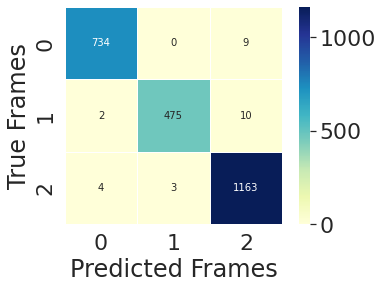

In [43]:
cm = confusion_matrix(y_test, prediction_test)
sns.set(rc={'figure.figsize':(15,15)}, font_scale=2.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Frames', ylabel='True Frames')

## Conclusion

To summarize, XGBoost and Machine Learning in general aids in the prediction of social behavior. When compared to other Machine Learning algorithms such as Random Forest and Gradient Boosting , XGBoost allowed us to learn and generalize from a small dataset within the same video to predict the outcome of a competition with 99% accuracy without fine tuning.

Body parts near the mouse's head, such as the nose, forehead, left, and right ear, was not representative when determining the winner/loser. This surprised us because we assumed that the body part closest to the reward point (the nose) would carry more significance, but this was not the case.

Finally, using information from the competition and 15 seconds before it begins, we can predict the outcome of the competition with 98% accuracy.

### Caveats

Even though the prediction accuracy score for this dataset allows for prediction of win/lose behavior, our results are not generalizable for every reward competition assay.  It predicts well enough for the labeled videos it was trained on (which share similar characteristics when it comes to lighting conditions, fps, camera zoom, pan and position, etc. However, the results could vary in different setups. Only two videos were tested and accuracy was only high when data from the same video was used for training. Therefore our results suggest that to achieve this level of accuracy with XGBoost, users would have to label data from any potential video they collect, limiting the application of this approach.

Additionally, using a high-res camera for the experiments could carry more meaningful information that can help us model in a better way   

### Future Directions

To increase our confidence in the model and the results presented, a possible direction would be to perform external validation. This way, we could use a different dataset to test our approach and decrease bias.


### Other Plots

In [44]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks across frames')

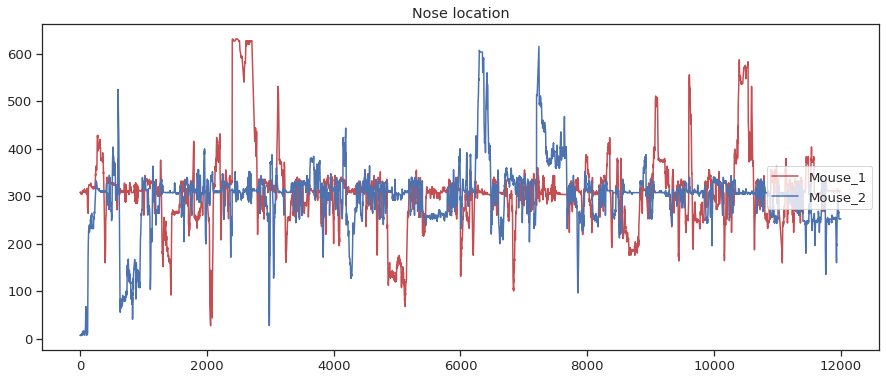

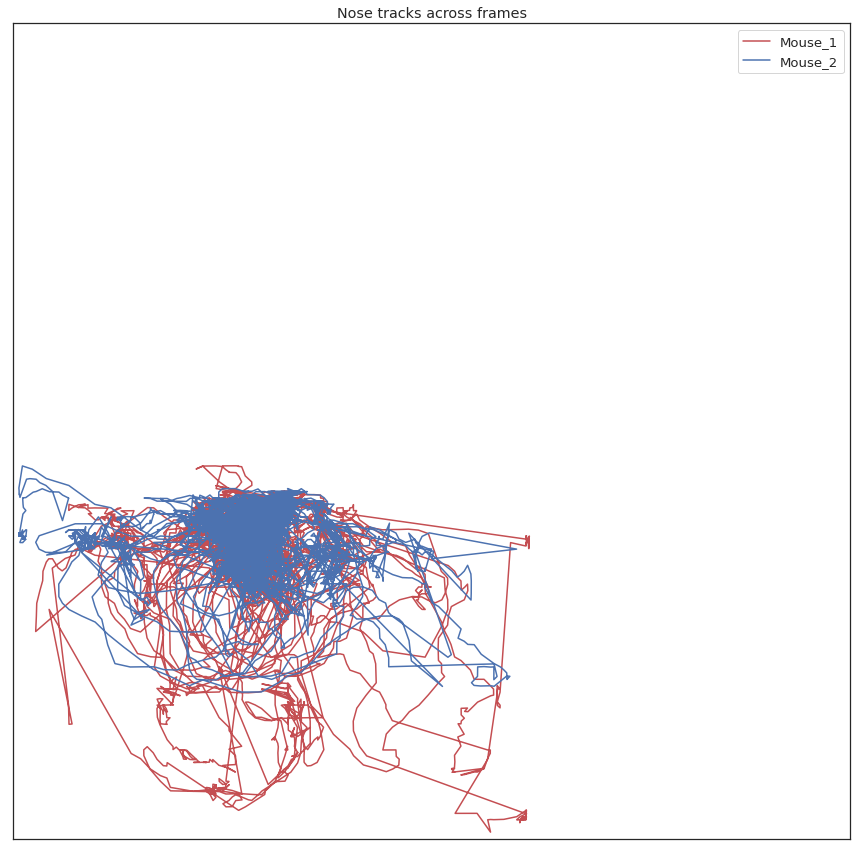

In [45]:
# Figure 1
plt.figure()

plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')
# plt.plot(-1*nose_loc[:,1,0], 'r')
# plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")

plt.title('Nose location')

# Figure 2
plt.figure(figsize=(15,15))

plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks across frames')

## More advanced visualizations (In Progress)

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [46]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [47]:
thx_vel_mouse1 = smooth_diff(nose_loc[:, :, 0].astype('float64'))
thx_vel_mouse2 = smooth_diff(nose_loc[:, :, 1].astype('float64'))

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

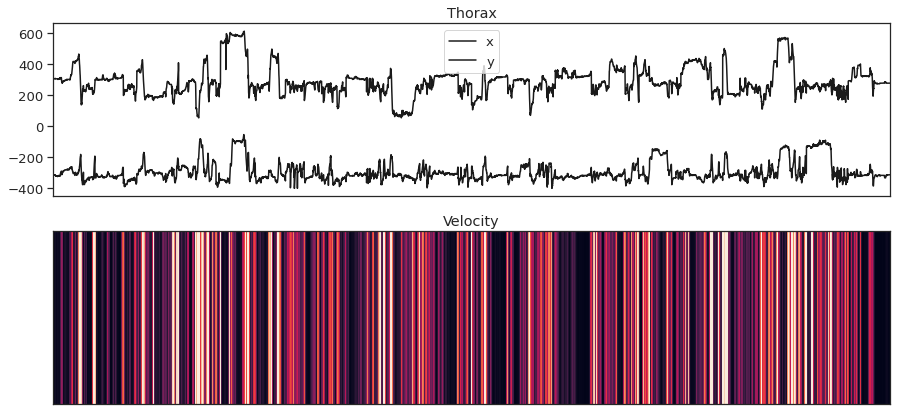

In [48]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
# Using the Transpose of the Matrix
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

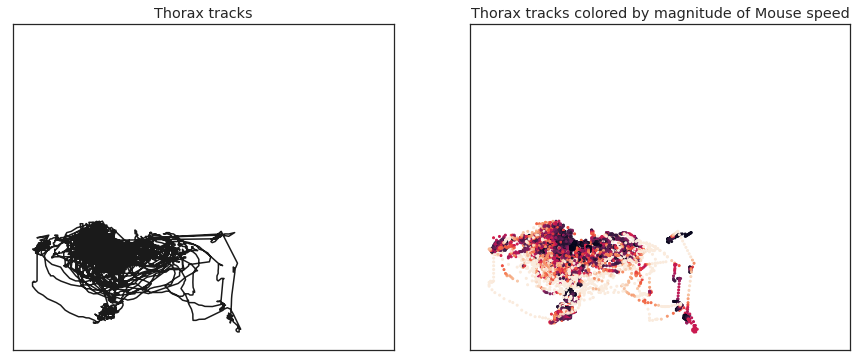

In [49]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [50]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

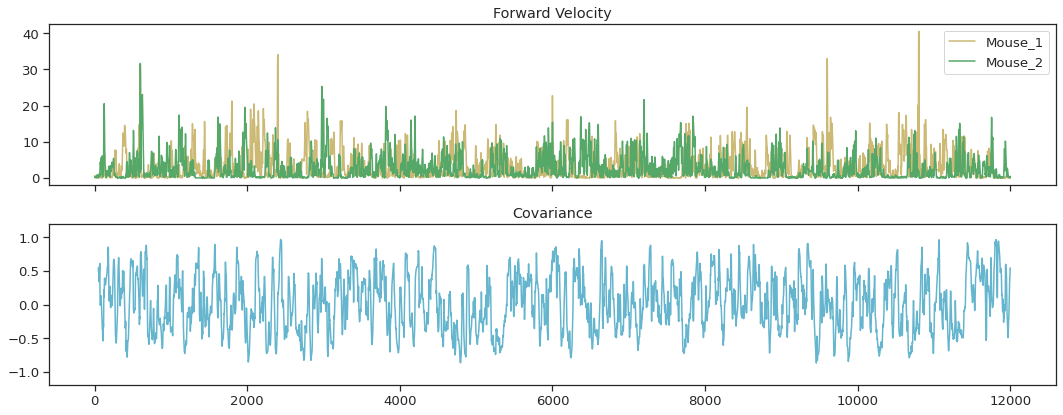

In [51]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run k-means on the velocities from each frame.


In [52]:
def instance_node_velocities(instance_idx):
    mouse_node_tracks = tracks[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((n_frames, n_bodyparts))

    for n in range(0, n_bodyparts):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_tracks[:, n, :])
    
    return mouse_node_velocities

In [53]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(n_bodyparts), bodyparts, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

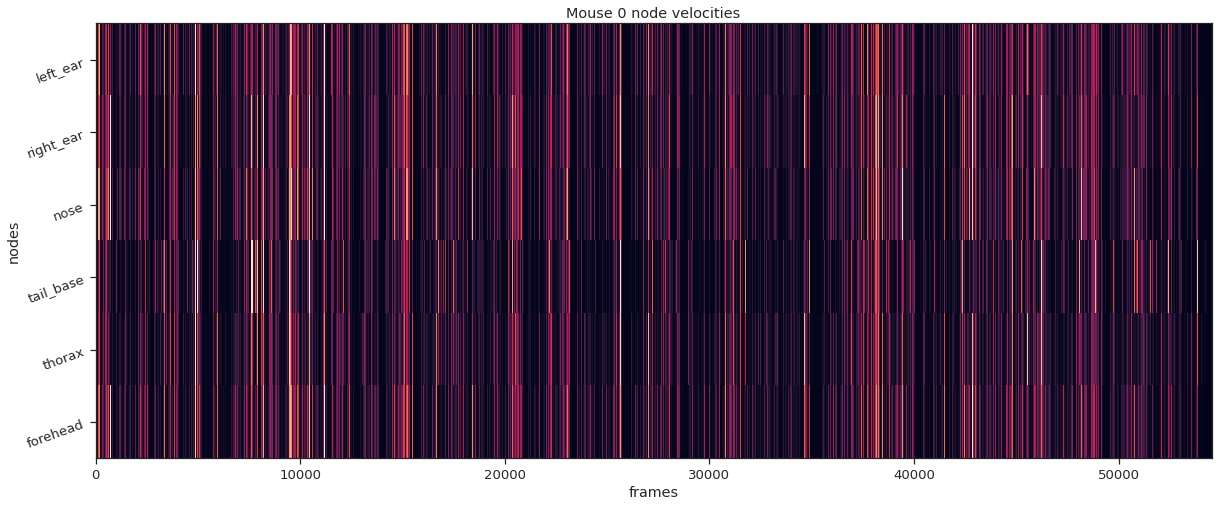

In [54]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

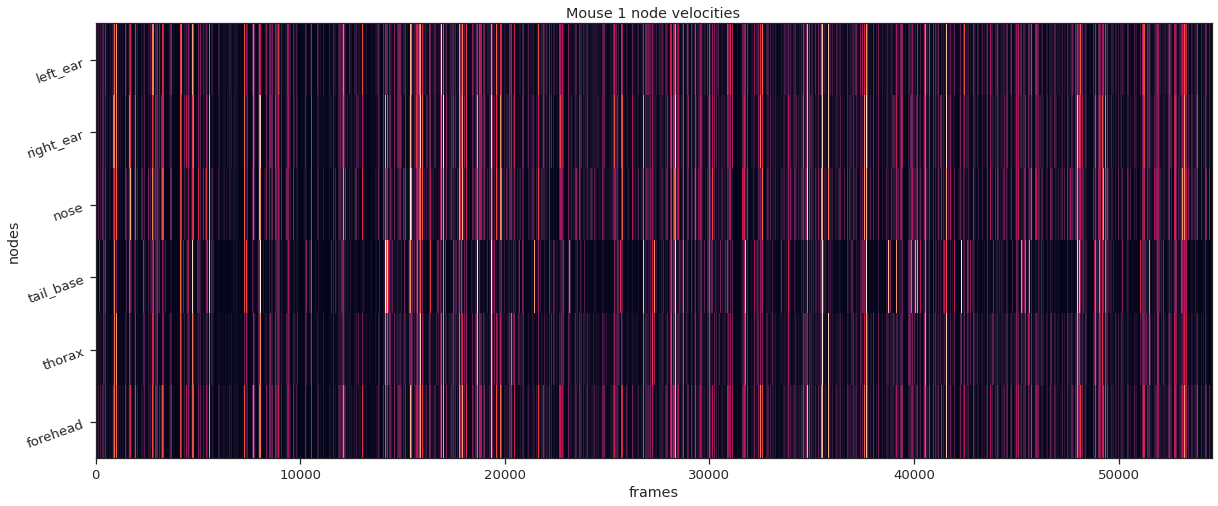

In [55]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [56]:
from sklearn.cluster import KMeans

In [57]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

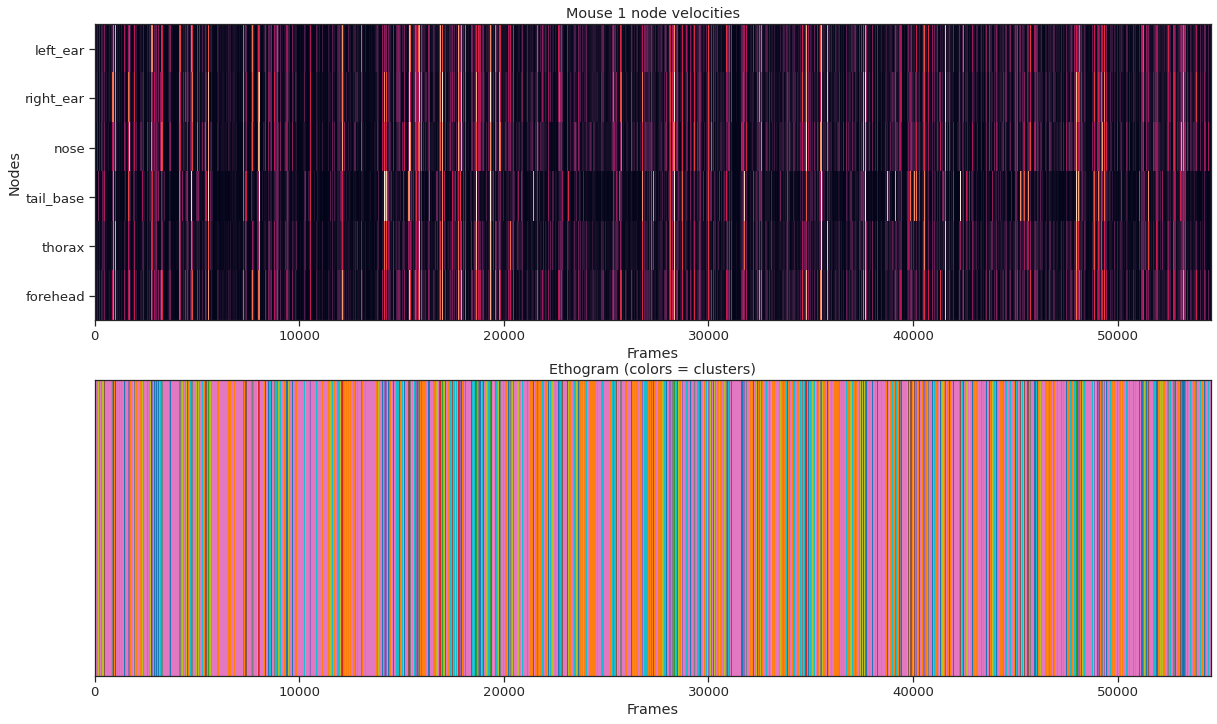

In [58]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(n_bodyparts))
ax1.set_yticklabels(bodyparts);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,n_frames)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");